In [1]:
import sqlite3 as sql
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

import scipy.optimize as optimize
from scipy import stats as sci
import math
from pprint import pprint

from collections import defaultdict
from typing import List
from tqdm import tqdm


In [2]:
sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
# getHistoParam:
# Nbins, binwidth, bins, counts, bin_centers  = 
from DB_lister import list_content, list_tables
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam()

In [3]:
sys.path.append('/groups/icecube/cyan/factory/DOMification/')
from DBDomification import convertDBtoDF, runDOMificationOnDB, convertDBtoDB

In [6]:
HE_TauNu_DB = '/groups/icecube/petersen/GraphNetDatabaseRepository/ExampleDBFilesFromAske_HEneutrinos_30Aug2024/Level2_NuTau_NuGenCCNC.022085.000007.db'
HE_Corsika_DB = '/groups/icecube/petersen/GraphNetDatabaseRepository/ExampleDBFilesFromAske_HEneutrinos_30Aug2024/Level2_IC86.2016_corsika.020848.002000.db'
Norhtern_DB = '/groups/icecube/petersen/GraphNetDatabaseRepository/northeren_tracks/dev_northern_tracks_full_part_1/data/dev_northern_tracks_full_part_1.db'
Frederiks_Merged_DB = '/groups/icecube/petersen/GraphNetDatabaseRepository/high_low_database/merged.db'
Andreas_E_DB = '/groups/icecube/petersen/GraphNetDatabaseRepository/high_energy_data_converted_by_Andreas_M/sqlite_db/NuEMerged.db'
Andreas_Mu_DB = '/groups/icecube/petersen/GraphNetDatabaseRepository/high_energy_data_converted_by_Andreas_M/sqlite_db/NuMuMerged.db'
Andreas_muonGun_DB = '/groups/icecube/petersen/GraphNetDatabaseRepository/high_energy_data_converted_by_Andreas_M/sqlite_db/MuonGunMerged.db'
new_retro_DB = '/groups/icecube/petersen/GraphNetDatabaseRepository/osc_next_database_new_muons_peter/Merged_db/osc_next_level3_v2.00_genie_muongun_noise_120000_140000_160000_139008_888003_retro.db'

In [5]:
list_tables(Frederiks_Merged_DB)
list_tables(Andreas_E_DB)
list_tables(Andreas_muonGun_DB)
list_tables(new_retro_DB)
list_tables(Norhtern_DB)

['SplitInIcePulses', 'event_no_SplitInIcePulses', 'truth', 'temp_table']
['SplitInIcePulses', 'event_no_SplitInIcePulses', 'SplitInIceDSTPulses', 'event_no_SplitInIceDSTPulses', 'truth']
['SplitInIcePulses', 'event_no_SplitInIcePulses', 'SplitInIceDSTPulses', 'event_no_SplitInIceDSTPulses', 'truth']
['SplitInIcePulses', 'event_no_SplitInIcePulses', 'truth', 'retro']
['truth', 'tum_dnn', 'event_no_tum_dnn', 'spline_mpe_ic', 'event_no_spline_mpe_ic', 'TWSRTHVInIcePulsesIC', 'event_no_TWSRTHVInIcePulsesIC', 'InIceDSTPulses', 'event_no_InIceDSTPulses', 'HVInIcePulses', 'event_no_HVInIcePulses', 'SRTHVInIcePulses', 'event_no_SRTHVInIcePulses', 'InIcePulses', 'event_no_InIcePulses']


In [7]:
Nlines_model = 100_000

In [9]:
df_Corsika = convertDBtoDF(HE_Corsika_DB, 'SRTInIcePulses')#, Nlines_model = 3_000_000)
# conversion took 
# 2_141_928 -> 18 sec

Loading 2141928 rows from SRTInIcePulses in /groups/icecube/petersen/GraphNetDatabaseRepository/ExampleDBFilesFromAske_HEneutrinos_30Aug2024/Level2_IC86.2016_corsika.020848.002000.db


In [8]:
df_F_merged = convertDBtoDF(Frederiks_Merged_DB, 'SplitInIcePulses', Nlines_model = Nlines_model)
# conversion took 
# 5_000_000 -> 40 sec
# 10_000_000 -> 1 min 50 sec

Loading 100000 rows from SplitInIcePulses in /groups/icecube/petersen/GraphNetDatabaseRepository/high_low_database/merged.db


In [10]:
df_A_e_merged = convertDBtoDF(Andreas_E_DB, 'SplitInIcePulses', Nlines_model = Nlines_model)
df_A_mu_merged = convertDBtoDF(Andreas_Mu_DB, 'SplitInIcePulses', Nlines_model = Nlines_model)
# conversion took 
# 5_000_000 -> 1 min 20 sec
# 10_000_000 -> 3 min 20 sec

Loading 100000 rows from SplitInIcePulses in /groups/icecube/petersen/GraphNetDatabaseRepository/high_energy_data_converted_by_Andreas_M/sqlite_db/NuEMerged.db
Loading 100000 rows from SplitInIcePulses in /groups/icecube/petersen/GraphNetDatabaseRepository/high_energy_data_converted_by_Andreas_M/sqlite_db/NuMuMerged.db


In [11]:
df_A_muonGun = convertDBtoDF(Andreas_muonGun_DB, 'SplitInIcePulses', Nlines_model = Nlines_model)
# conversion took 
# 5_000_000 -> 40 sec
# 10_000_000 -> 1 min 30 sec

Loading 100000 rows from SplitInIcePulses in /groups/icecube/petersen/GraphNetDatabaseRepository/high_energy_data_converted_by_Andreas_M/sqlite_db/MuonGunMerged.db


In [12]:
df_new_retro = convertDBtoDF(new_retro_DB, 'SplitInIcePulses', Nlines_model = Nlines_model)
# conversion took 
# 5_000_000 -> 30 sec
# 10_000_000 -> 1 min 10 sec

Loading 100000 rows from SplitInIcePulses in /groups/icecube/petersen/GraphNetDatabaseRepository/osc_next_database_new_muons_peter/Merged_db/osc_next_level3_v2.00_genie_muongun_noise_120000_140000_160000_139008_888003_retro.db


In [13]:
df_new_retro.columns

Index(['charge', 'dom_time', 'dom_x', 'dom_y', 'dom_z', 'event_no',
       'event_time', 'is_bad_dom', 'is_bright_dom', 'is_errata_dom',
       'is_saturated_dom', 'pmt_area', 'rde', 'width'],
      dtype='object')

In [14]:
# unique combinations of string and dom
def printUniqueStringDomCombination(df):
    unique_combinations = df[['string', 'dom_number']].drop_duplicates().shape[0]
    print(f'Unique combinations of string and dom: {unique_combinations}')
printUniqueStringDomCombination(df_Corsika)
printUniqueStringDomCombination(df_F_merged)
printUniqueStringDomCombination(df_A_e_merged)
printUniqueStringDomCombination(df_A_mu_merged)
printUniqueStringDomCombination(df_A_muonGun)

# Corsika
# 1_000_000 : 5074
# 2_000_000 : 5074
# 3_000_000 : 5074

# Frederiks Merged
# 1_000_000 : 5070
# 5_000_000 : 5074
# 10_000_000 : 5074

# Andreas E Merged
# 1_000_000 : 5075
# 5_000_000 : 5075
# 10_000_000 : 5075

# Andreas Mu Merged
# 1_000_000 : 5075
# 5_000_000 : 5075
# 10_000_000 : 5075

# Andreas MuonGun
# 1_000_000 : 5070
# 5_000_000 : 5074
# 10_000_000 : 5074

Unique combinations of string and dom: 5074
Unique combinations of string and dom: 4094
Unique combinations of string and dom: 5072
Unique combinations of string and dom: 5075
Unique combinations of string and dom: 4094


In [15]:
# def makeCSVofUniqueStringDomCombinationAndDomXYZ(df, filename):
#     df_unique_doms = df[['string', 'dom_number', 'dom_x', 'dom_y', 'dom_z']].groupby(['string', 'dom_number']).first().reset_index()
#     with open(filename, 'w') as f:
#         f.write(','.join(df_unique_doms.columns) + ',\n')
        
#         for row in df_unique_doms.values:
#             f.write(','.join(map(str, row)) + ',\n')
    
def makeCSVofUniqueStringDomCombinationAndDomXYZ(df, filename):
    df_unique_doms = df[['string', 'dom_number', 'dom_x', 'dom_y', 'dom_z']].groupby(['string', 'dom_number']).first().reset_index()
    df_unique_doms.to_csv(filename, index = False)

In [16]:
def findMissingDoms(df):
    df_unique_doms = df[['string', 'dom_number', 'dom_x', 'dom_y', 'dom_z']].groupby(['string', 'dom_number']).first().reset_index()
    STRINGMAX = 86
    DOMMAX = 60
    all_combinations = pd.MultiIndex.from_product([range(1, STRINGMAX+1), range(1, DOMMAX+1)], names=['string', 'dom_number'])
    df_unique_doms.set_index(['string', 'dom_number'], inplace=True)
    missing_combinations = all_combinations.difference(df_unique_doms.index)
    print(f'shape of missing_combinations: {missing_combinations.shape}')
    missing_df = pd.DataFrame(list(missing_combinations), columns=['string', 'dom_number'])
    # missing_df.to_csv('missing_doms.csv', index = False)
    return missing_df

In [17]:
missing_Corsika = findMissingDoms(df_Corsika)
missing_F_merged = findMissingDoms(df_F_merged)
missing_A_e_merged = findMissingDoms(df_A_e_merged)
missing_A_mu_merged = findMissingDoms(df_A_mu_merged)
missing_A_muonGun = findMissingDoms(df_A_muonGun)

shape of missing_combinations: (86,)
shape of missing_combinations: (1066,)
shape of missing_combinations: (88,)
shape of missing_combinations: (85,)
shape of missing_combinations: (1066,)


In [28]:
def findDifferences(df1, df2):
    diff_in_df1 = df1.merge(df2, how='outer', indicator=True).query('_merge == "left_only"').drop(columns='_merge')
    diff_in_df2 = df2.merge(df1, how='outer', indicator=True).query('_merge == "left_only"').drop(columns='_merge')
    print(f'rows in df1 but not in df2: {diff_in_df1}')
    print(f'rows in df2 but not in df1: {diff_in_df2}')
    return diff_in_df1, diff_in_df2

In [26]:
missing_F_merged.equals(missing_Corsika)

False

In [30]:
findDifferences(missing_F_merged, missing_A_e_merged)

rows in df1 but not in df2:     string  dom_number
2        5          22
3        6          35
19       9          16
23      18          37
28      25          35
32      28          36
38      30          60
71      59          46
rows in df2 but not in df1:     string  dom_number
22      13          36
77      67          49
78      67          50


(    string  dom_number
 2        5          22
 3        6          35
 19       9          16
 23      18          37
 28      25          35
 32      28          36
 38      30          60
 71      59          46,
     string  dom_number
 22      13          36
 77      67          49
 78      67          50)

In [29]:
def combineDFs(df1, df2):
    df1_unique_doms = df1[['string', 'dom_number', 'dom_x', 'dom_y', 'dom_z']].groupby(['string', 'dom_number']).first().reset_index()
    df2_unique_doms = df2[['string', 'dom_number', 'dom_x', 'dom_y', 'dom_z']].groupby(['string', 'dom_number']).first().reset_index()
    combined_df = pd.concat([df1_unique_doms, df2_unique_doms], ignore_index=True)
    combined_df.drop_duplicates(inplace=True)
    return combined_df

In [31]:
df_F_A_e = combineDFs(df_F_merged, df_A_e_merged)
# 

In [32]:
df_F_A_e

,string,dom_number,dom_x,dom_y,dom_z
0,1.0,1.0,-256.14,-521.08,496.03
1,1.0,2.0,-256.14,-521.08,479.01
2,1.0,3.0,-256.14,-521.08,461.99
3,1.0,4.0,-256.14,-521.08,444.97
4,1.0,5.0,-256.14,-521.08,427.95
...,...,...,...,...,...
6106,18.0,37.0,79.41,-248.24,-113.84
6520,25.0,35.0,-121.77,-171.03,-76.43
6698,28.0,36.0,248.15,-111.87,-97.69
6837,30.0,60.0,500.43,-58.45,-502.37


In [34]:
makeCSVofUniqueStringDomCombinationAndDomXYZ(df_F_A_e, 'unique_string_dom_combinations_F_A_e.csv')

In [33]:
findMissingDoms(df_F_A_e)

,string,dom_number
0,1,46
1,5,21
2,7,34
3,7,35
4,7,36
...,...,...
77,74,18
78,79,55
79,79,56
80,86,27


In [ ]:
def fillMissingDoms(df_unique_doms):
    missing_df = findMissingDoms(df_unique_doms)
    print(missing_df    )

    for string in missing_df['string'].unique():
        current_string_df = df_unique_doms[df_unique_doms['string'] == string]
        
        # Get dom_x and dom_y (identical for all DOMs in this string)
        dom_x = current_string_df['dom_x'].iloc[0]
        dom_y = current_string_df['dom_y'].iloc[0]
        
        missing_doms = missing_df[missing_df['string'] == string]['dom_number'].tolist()
        
        all_dom_numbers = np.arange(1, 61)  # Considering all possible DOM numbers from 1 to 60
        existing_doms = current_string_df[['dom_number', 'dom_z']].set_index('dom_number')
        interpolated_dom_z = existing_doms.reindex(all_dom_numbers).interpolate(method='linear')

        first_existing_dom = current_string_df['dom_number'].min()
        last_existing_dom = current_string_df['dom_number'].max()
        print(f'last_existing_dom: {last_existing_dom}')
        
        if missing_doms[0] < first_existing_dom:
            gap = existing_doms.loc[first_existing_dom, 'dom_z'] - existing_doms.loc[first_existing_dom + 1, 'dom_z']
            for dom_number in missing_doms:
                if dom_number < first_existing_dom:
                    interpolated_dom_z.loc[dom_number] = interpolated_dom_z.loc[first_existing_dom] + gap * (first_existing_dom - dom_number)
        
        if missing_doms[-1] > last_existing_dom:
            gap = existing_doms.loc[last_existing_dom, 'dom_z'] - existing_doms.loc[last_existing_dom - 1, 'dom_z']
            for dom_number in missing_doms:
                if dom_number > last_existing_dom:
                    interpolated_dom_z.loc[dom_number] = interpolated_dom_z.loc[last_existing_dom] + gap * (dom_number - last_existing_dom)

        for dom_number in missing_doms:
            df_unique_doms = pd.concat([
                df_unique_doms,
                pd.DataFrame({
                    'string': [string],
                    'dom_number': [dom_number],
                    'dom_x': [dom_x],
                    'dom_y': [dom_y],
                    'dom_z': [round(interpolated_dom_z.loc[dom_number, 'dom_z'], 2)]
                })
            ], ignore_index=True)

    df_unique_doms = df_unique_doms.sort_values(by=['string', 'dom_number']).reset_index(drop=True)
    
    return df_unique_doms

In [36]:
df_completed = fillMissingDoms(df_F_A_e)

In [ ]:
findMissingDoms(df_completed)

In [37]:
df_completed

,string,dom_number,dom_x,dom_y,dom_z
0,1.0,1.0,-256.14,-521.08,496.03
1,1.0,2.0,-256.14,-521.08,479.01
2,1.0,3.0,-256.14,-521.08,461.99
3,1.0,4.0,-256.14,-521.08,444.97
4,1.0,5.0,-256.14,-521.08,427.95
...,...,...,...,...,...
5155,86.0,56.0,-10.97,6.72,-472.39
5156,86.0,57.0,-10.97,6.72,-479.39
5157,86.0,58.0,-10.97,6.72,-486.40
5158,86.0,59.0,-10.97,6.72,-493.41


In [44]:
df_completed[df_completed['string'] == 21]

,string,dom_number,dom_x,dom_y,dom_z
1200,21.0,1.0,443.60,-194.16,516.67
1201,21.0,2.0,443.60,-194.12,499.65
1202,21.0,3.0,443.63,-194.08,482.63
1203,21.0,4.0,443.66,-194.04,465.61
1204,21.0,5.0,443.70,-194.02,448.59
1205,21.0,6.0,443.75,-194.01,431.57
1206,21.0,7.0,443.80,-194.01,414.55
1207,21.0,8.0,443.85,-194.02,397.53
1208,21.0,9.0,443.89,-194.04,380.51
1209,21.0,10.0,443.93,-194.08,363.49


In [38]:
makeCSVofUniqueStringDomCombinationAndDomXYZ(df_completed, 'unique_string_dom_completed.csv')

Number of unique dom positions: 86


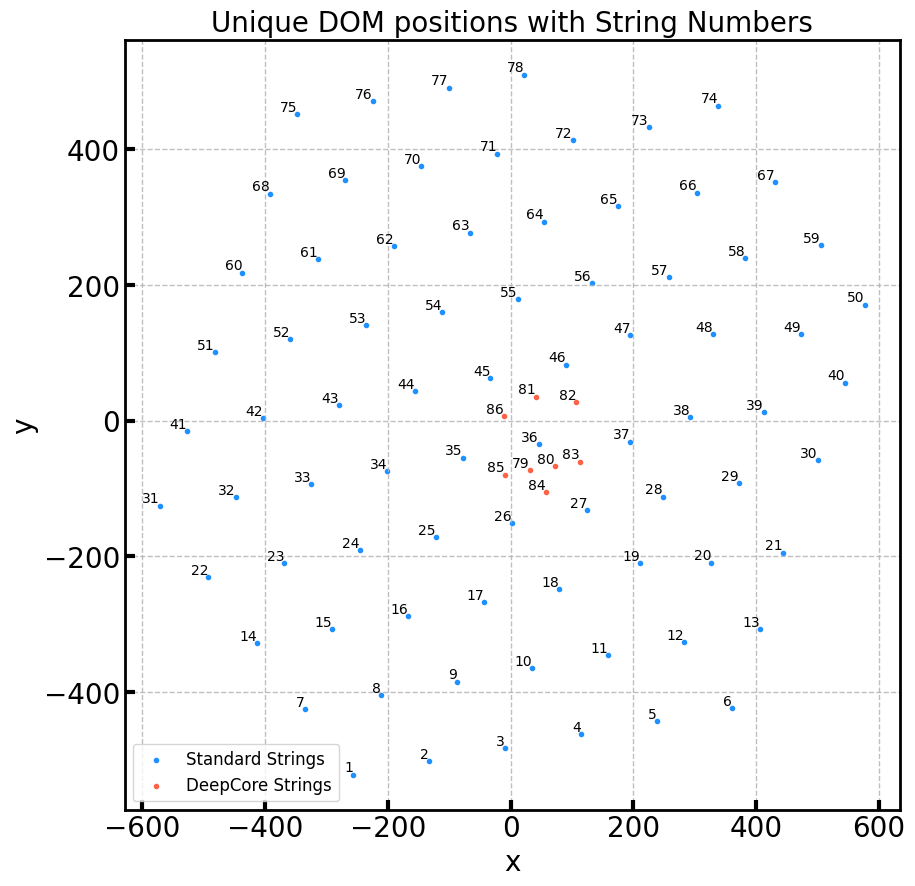

In [39]:
def plotXYpositionsWithLabels(df):
    unique_dom_xy = df.groupby(['string']).first().reset_index()
    print(f'Number of unique dom positions: {unique_dom_xy.shape[0]}')
    standardString = unique_dom_xy[unique_dom_xy['string'] <79]
    deepCoreString = unique_dom_xy[unique_dom_xy['string'] >= 79]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(standardString['dom_x'], standardString['dom_y'], marker='o', color = getColour(0), label='Standard Strings')
    ax.scatter(deepCoreString['dom_x'], deepCoreString['dom_y'], marker='o', color = getColour(2), label='DeepCore Strings')
    
    for _, row in unique_dom_xy.iterrows():
        ax.text(row['dom_x'], row['dom_y'], str(int(row['string'])), fontsize=10, ha='right', va='bottom')
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Unique DOM positions with String Numbers')
    ax.legend()

plotXYpositionsWithLabels(df_completed)


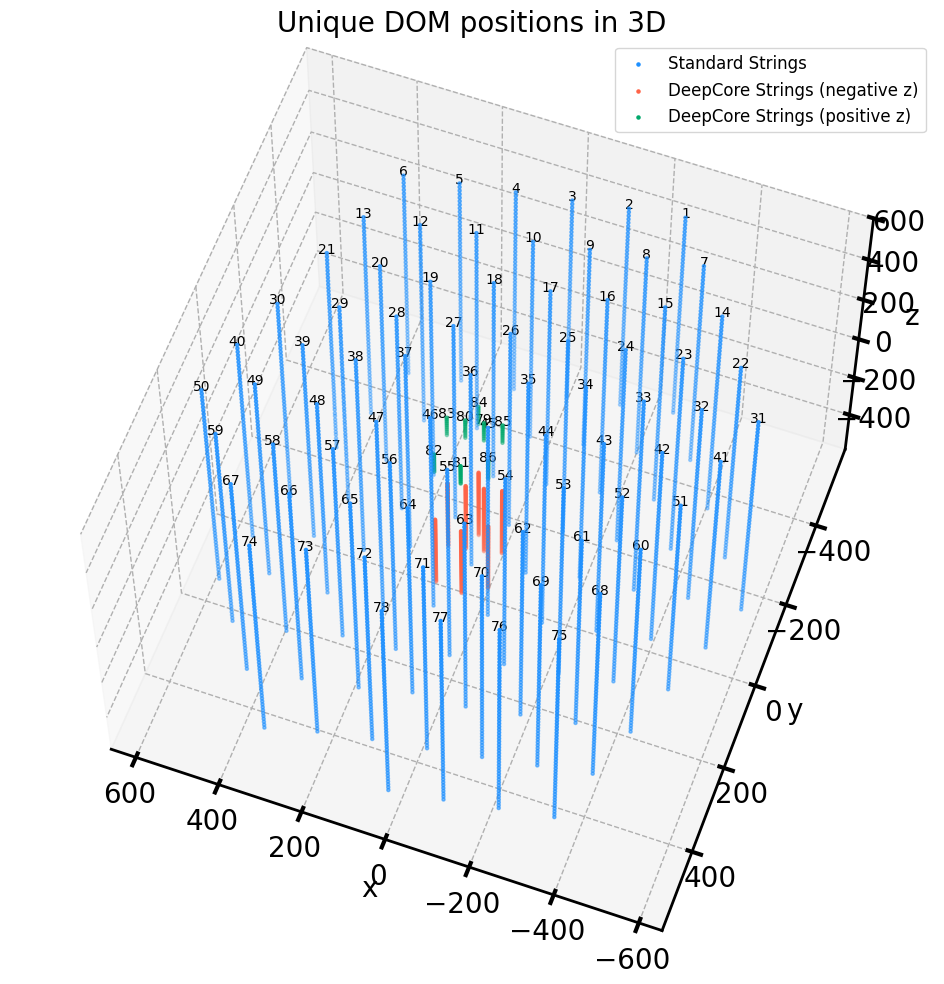

In [46]:
def plot3DDOMpositions(df, elev=60, azim=110):
    standardString = df[df['string'] < 79]
    deepCoreString_positive = df[(df['string'] >= 79) & (df['dom_z'] > 0)]
    deepCoreString_negative = df[(df['string'] >= 79) & (df['dom_z'] < 0)]
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(standardString['dom_x'], standardString['dom_y'], standardString['dom_z'], 
            marker='.', color=getColour(0), label='Standard Strings')
    ax.scatter(deepCoreString_negative['dom_x'], deepCoreString_negative['dom_y'], deepCoreString_negative['dom_z'], 
            marker='.', color=getColour(2), label='DeepCore Strings (negative z)')
    ax.scatter(deepCoreString_positive['dom_x'], deepCoreString_positive['dom_y'], deepCoreString_positive['dom_z'],
            marker='.', color=getColour(3), label='DeepCore Strings (positive z)')
    
    string_text_z = 500
    for string in df['string'].unique():
        string_df = df[df['string'] == string]
        top_dom = string_df.loc[string_df['dom_z'].idxmax()]
        ax.text(top_dom['dom_x'], top_dom['dom_y'], top_dom['dom_z'],
                f'{int(string)}', fontsize=10, ha='center', color='black')
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('Unique DOM positions in 3D')
    ax.view_init(elev=elev, azim=azim)
    ax.legend()
plot3DDOMpositions(df_completed)